In [1]:
# 입력값 만으로도 학습하는 오토인코더
'''
- 주어진 데이터만으로 패턴을 찾는 비지도 학습
- 지도하급은 입력 x와 정답 y사이를 잇는 관계를 찾는 것
- 오차가 측정이 가능

- 비지도 학습은 정답이 없기 떄문에 오차값을 구하기 모호하다
- x를 입력받아 x를 예측, 신경망에 의미있는 정보가 샇이도록 설계된 신경망이 오토인코더
- 오토인코더는 입력도 x, 정답도 x
- 신경망은 범용근사자(universal function approximator) 로 근사치를 출력하기 때문에 x와 똑같은 출력을 내긴 힘듬
- 입력된 x를 복원 한다는 개념이 맞다
- 오차값에도 x를 얼마나 복원했는지 뜻하는 복원오차, 혹은 정보손실값 (reconsturction loss) 라는 용어를 사용

- 오토인코더 특징은 입력과 출력 크기는 같으나, 중간으로 갈수록 신경망 차원이 줄어듬
- 특이한 구조로 정보의 통로가 줄어들고 병목현상이 일어나 입력들의 특징이 압축됨
- 작은 차원에 고인 압축된 표현을 잠재 변수(latent variable) 간단히 z라 함
- 잠재 변수의 앞부분을 인코더(encoder) 뒷부분을 디코더(decoder) 라고함
- 오토인코더는 주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 쓰임
- 비정상 거래 검출, 데이터 시각화의 복원, 의미 추출, 이미지 검색 등에도 쓰임
'''

'\n- 주어진 데이터만으로 패턴을 찾는 비지도 학습\n- 지도하급은 입력 x와 정답 y사이를 잇는 관계를 찾는 것\n- 오차가 측정이 가능\n\n- 비지도 학습은 정답이 없기 떄문에 오차값을 구하기 모호하다\n- x를 입력받아 x를 예측, 신경망에 의미있는 정보가 샇이도록 설계된 신경망이 오토인코더\n- 오토인코더는 입력도 x, 정답도 x\n- 신경망은 범용근사자(universal function approximator) 로 근사치를 출력하기 때문에 x와 똑같은 출력을 내긴 힘듬\n- 입력된 x를 복원 한다는 개념이 맞다\n- 오차값에도 x를 얼마나 복원했는지 뜻하는 복원오차, 혹은 정보손실값 (reconsturction loss) 라는 용어를 사용\n\n- 오토인코더 특징은 입력과 출력 크기는 같으나, 중간으로 갈수록 신경망 차원이 줄어듬\n- 특이한 구조로 정보의 통로가 줄어들고 병목현상이 일어나 입력들의 특징이 압축됨\n- 작은 차원에 고인 압축된 표현을 잠재 변수(latent variable) 간단히 z라 함\n- 잠재 변수의 앞부분을 인코더(encoder) 뒷부분을 디코더(decoder) 라고함\n- 오토인코더는 주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 쓰임\n- 비정상 거래 검출, 데이터 시각화의 복원, 의미 추출, 이미지 검색 등에도 쓰임\n'

Using Device cpu
[Epoch 1]


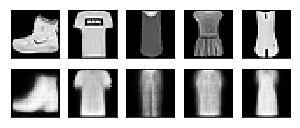

[Epoch 2]


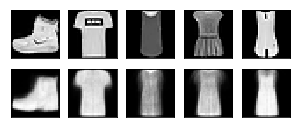

[Epoch 3]


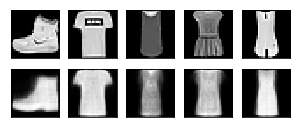

[Epoch 4]


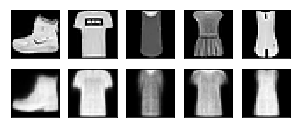

[Epoch 5]


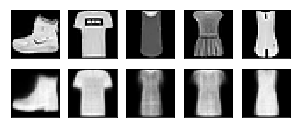

[Epoch 6]


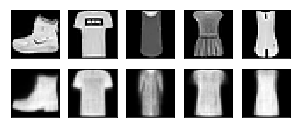

[Epoch 7]


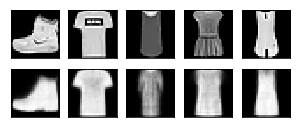

[Epoch 8]


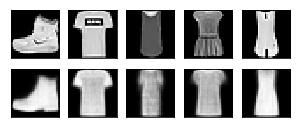

[Epoch 9]


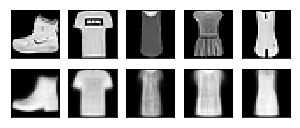

[Epoch 10]


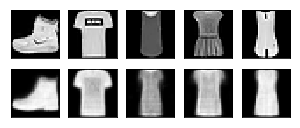

In [14]:
# 오토인코더 구현
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# 하이퍼 파라미터 준비
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('Using Device', DEVICE)


# 학습데이터 셋만 사용
# Fashion MNIST 데이터셋 로딩
trainset = datasets.FashionMNIST(
    root = './data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

# nn.Sequential을 이용하여 encoder 와 decoder 두 모듈을 묶어줌
# nn.Sequential 은 여러 모듈을 하나의 모듈로 묶는 역할을 함
# 각 레이어를 테이터가 순차적으로 지나갈 때 사용하면 코드를 간결하게 만들 수 있음 
# 계층과 활성화 함수를 정의해 주면 순서대로 값을 전달해 처리

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
# 모델과 최적화 함수 객체를 불러옴
# 최적화 함수는 Adam()이다, SGD의 변형 함수이며 학습중인 기울기를 참고하여 학습속도를 자동으로 변화
# 디코더에서 나온 값과 원본의 차이, 즉 오차를 계산하기 위해 평균제곱오차(mean squared loss) 오차 함수를 사용
# nn.MSELoss() 함수는 두 개의 같은 크기의 행렬을 받아 각 자리의 차이에서 제곱해서 평균을 구해주는 객체
# 이 객체를 '기준' 을 뜻하는 criterion 이라고 이름짓고 인스턴스 화
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

# 파이토치의 optim 모듈은 일반적으로 사용하는 최적화 알고리즘을 클래스의 형태로 제공
# 딥러닝에 자주 사용되는 SGD, RMSProp, Adam 등과 같은 다양한 최적화 알고리즘 제공

# 원본 이미지를 시각화 하기(첫 번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

# 학습하는 함수
# 입력인 x와 대상 레이블 y 모두 원본 이미지
# 오찻값은 디코더에서 나온 복원 이미지인 decoded와 원본 이미지(y)의 차이의 제곱
# 평균제곱오차를 계산해주는 criterion은 decoded에서 y를 빼고 제곱한 값의 평균을 구해 손실(오차)을 구함
# zero_grad() 함수로 기존에 남이 있을 수 있는 기울기에 대한 정보 초기화
# backward() 함수로 기울기를 구한 후
# optimizer의 step() 함수로 최적화를 진행
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)
    
    # 앞서 시각화를 위해 남겨둔 5개 이미지를 이폭만큼 학습을 마친 모델에 넣어 복원 이미지 만듬
    # 디코더에서 나온 이미지를 시각화(두번쨰 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    
    # 원본과 디코딩 결과 비교
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print('[Epoch {}]'.format(epoch))
    
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28, 28))
        
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    
    # cuda를 사용하면 모델의 출력값이 아직 gpu에 남아있을수 있다.
    # .to('cpu') 함수로 일반 메모리로 가져온 후 numpy()함수를 사용해 넘파이 행렬로 변환해야함
    for i in range(5):
        img = np.reshape(decoded_data.to('cpu').data.numpy()[i], (28, 28))
        
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
        
    plt.show()
        
    

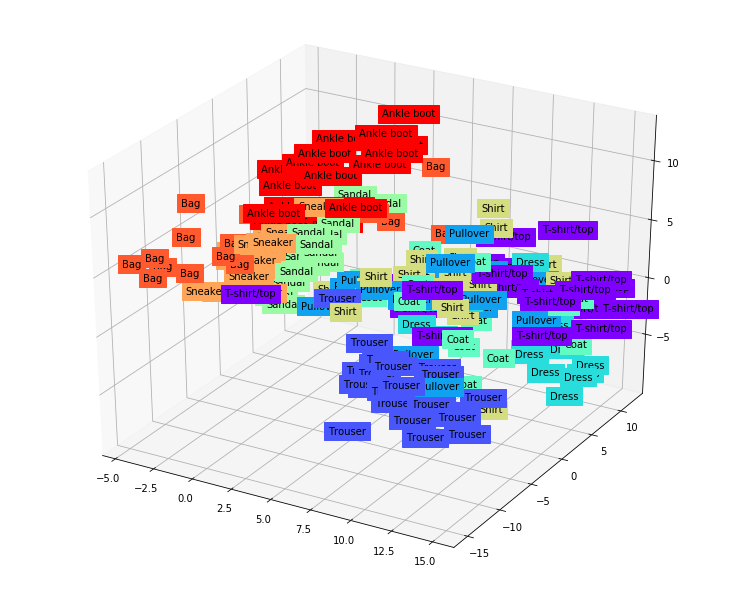

In [12]:
# 잠재 변수 들여다보기
# 오토인코더에서 나온 잠재 변수들이 3차원에서 어떻게 분포되는지 확인

view_data = trainset.data[:200].view(-1, 28 * 28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to('cpu')

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)
    
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
    
plt.show()

In [15]:
# 잡음 제거 오토인코더 (denosing autoencoder)
# 오토인코더는 일종의 압축을 함, 데이터 특성의 우선순위를 매기고 낮은 순위의 데이터를 버림
# 잡음제거 오토인코더 아이디어는 중요한 특징을 추출하는 오토인코더 특징을 이용. 비교적 '덜 중요한 데이터' 인 잡음을 제거
# 기본적인 오토인코더와 큰 차이는 없으며 학습할 떄 입력에 잡음을 더하여 복원능력을 강화

def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x) # 입력에 노이즈 추가
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    return avg_loss / len(train_loader)

for epoch in range(1, EPOCH + 1):
    loss = train(autoencoder, train_loader)
    print('[Epoch {}] loss: {}'.format(epoch, loss))

[Epoch 1] loss: 0.06279991030581851
[Epoch 2] loss: 0.06228119641272371
[Epoch 3] loss: 0.06215492002507136
[Epoch 4] loss: 0.06200057087835473
[Epoch 5] loss: 0.06214909798809206
[Epoch 6] loss: 0.061904976394639086
[Epoch 7] loss: 0.06193042614820923
[Epoch 8] loss: 0.06216950740005924
[Epoch 9] loss: 0.061965004054468066
[Epoch 10] loss: 0.06158441830990411


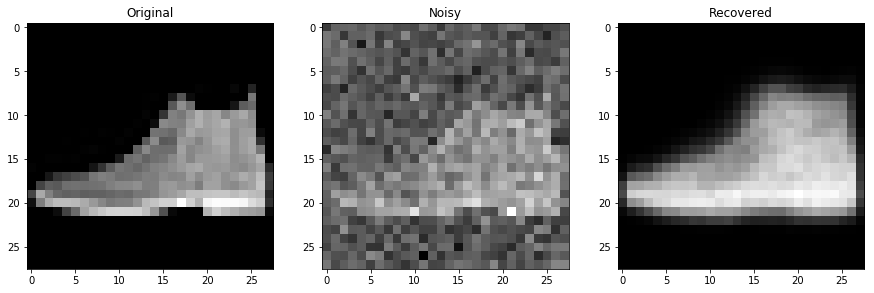

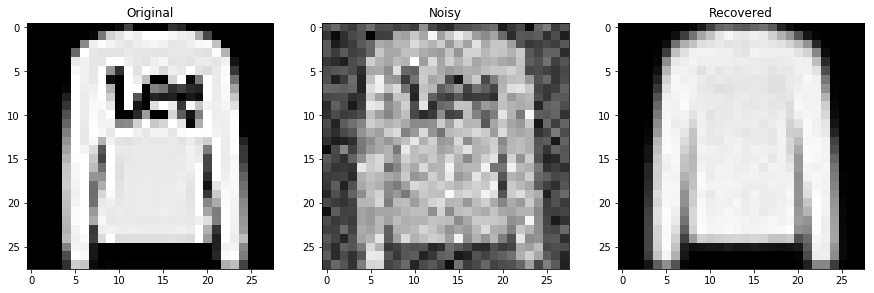

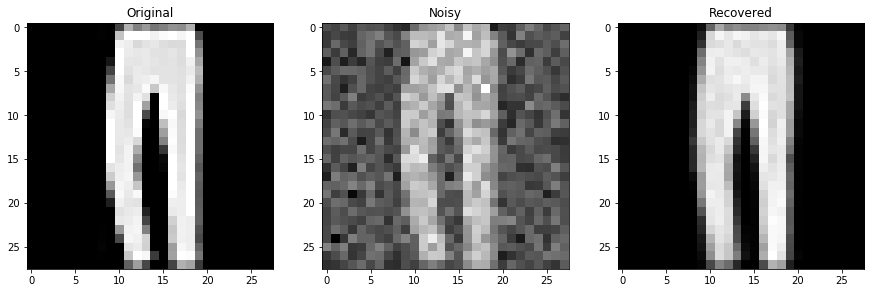

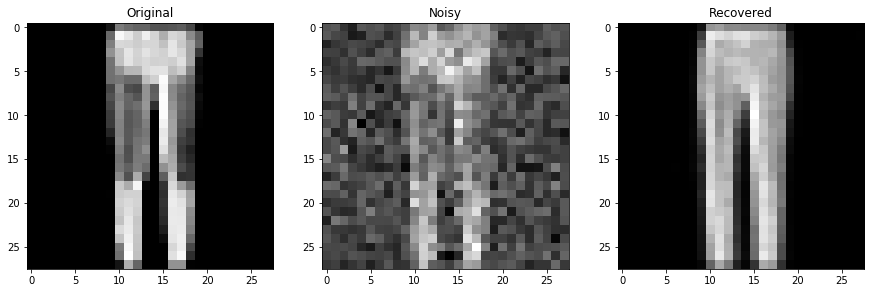

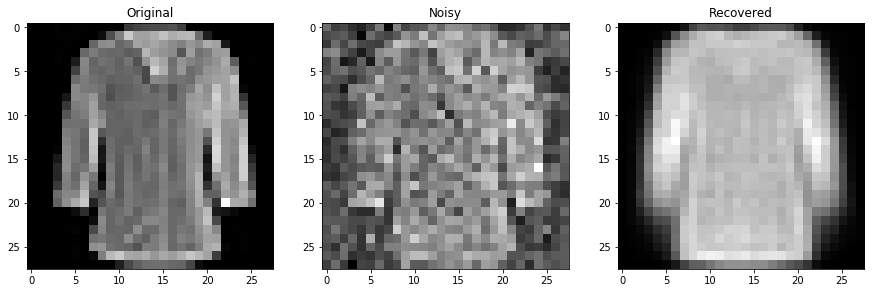

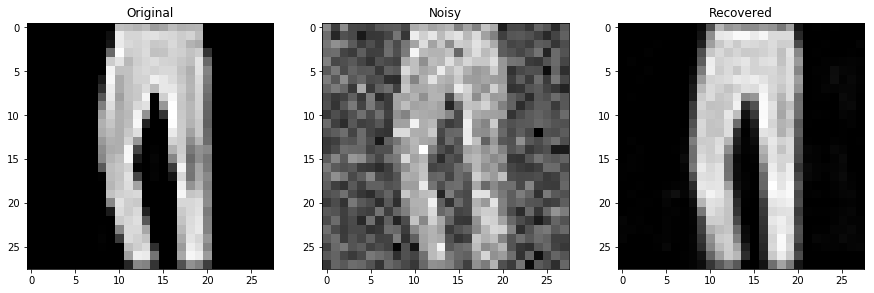

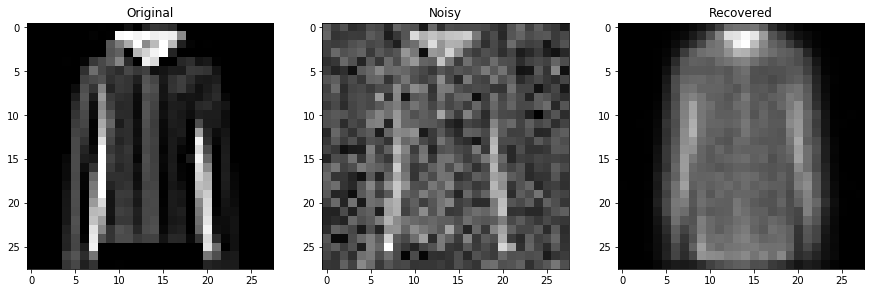

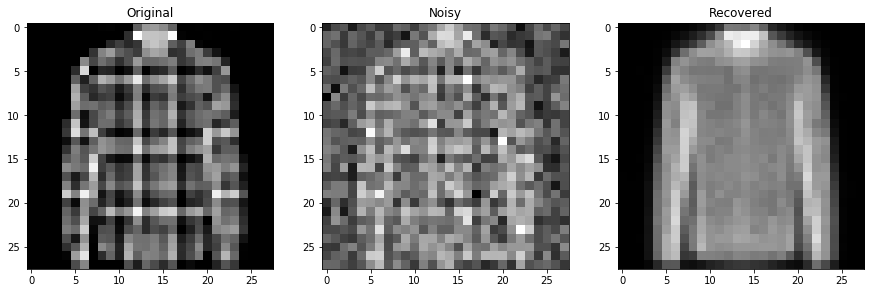

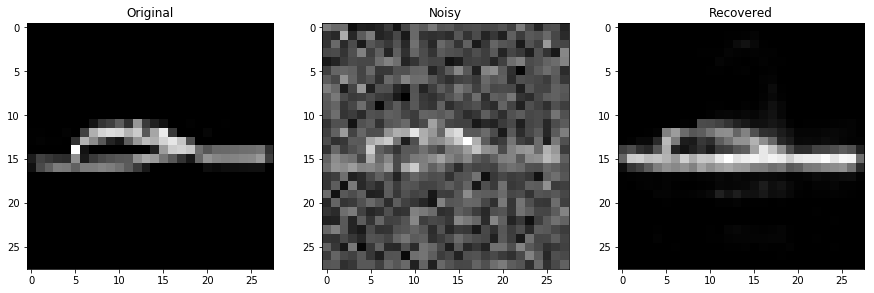

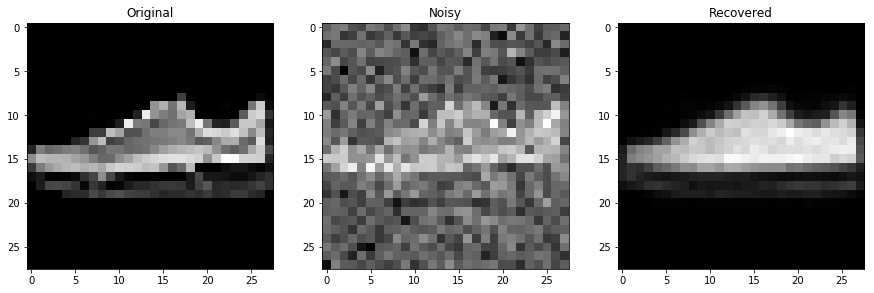

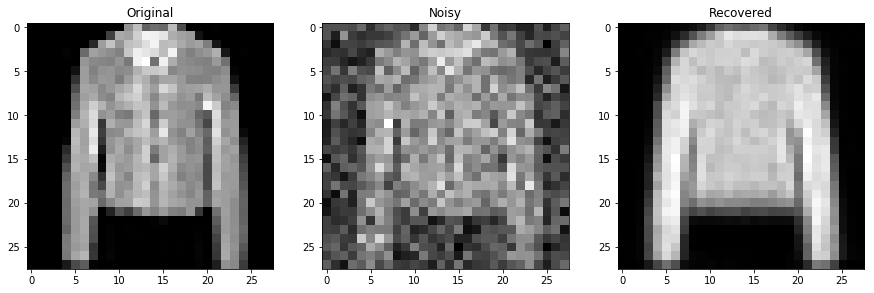

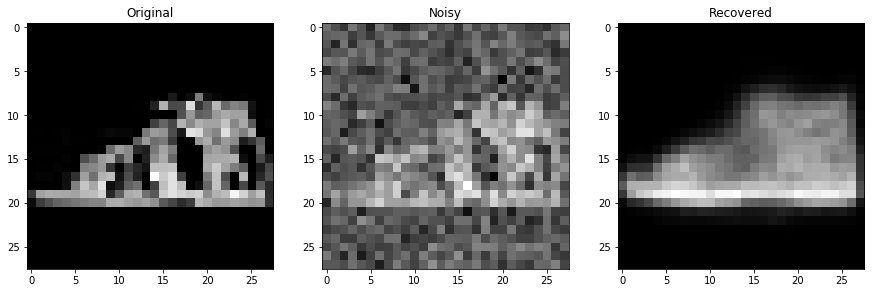

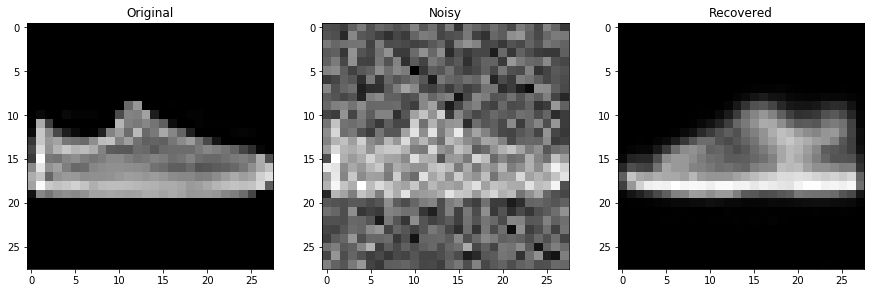

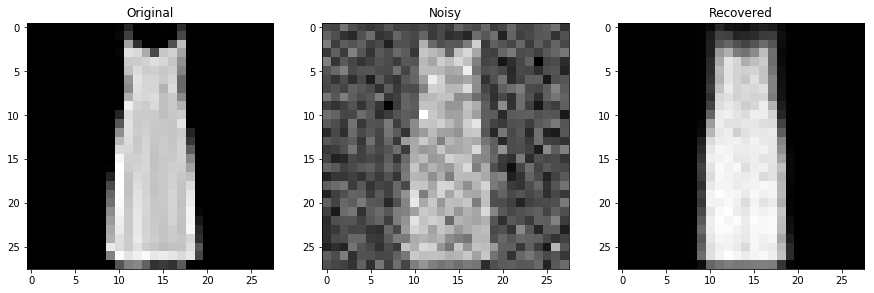

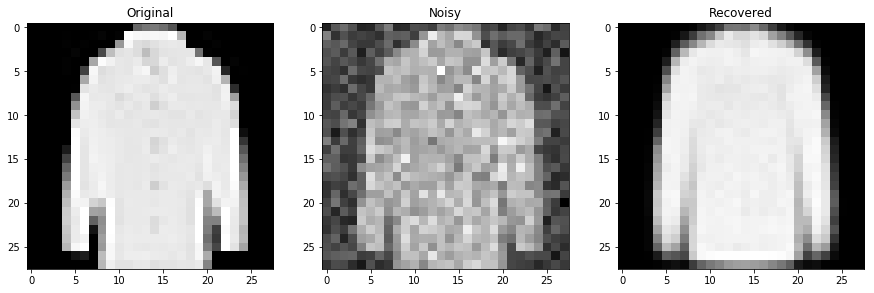

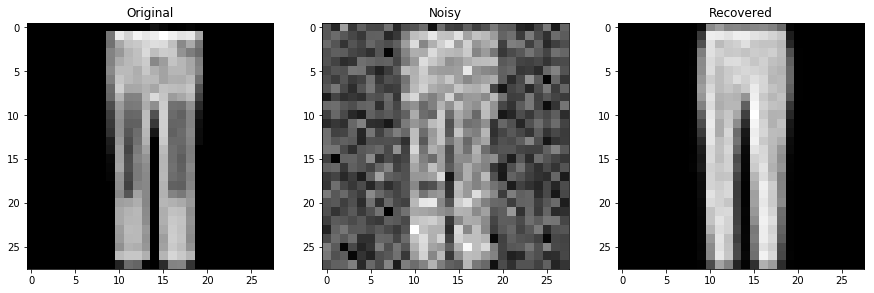

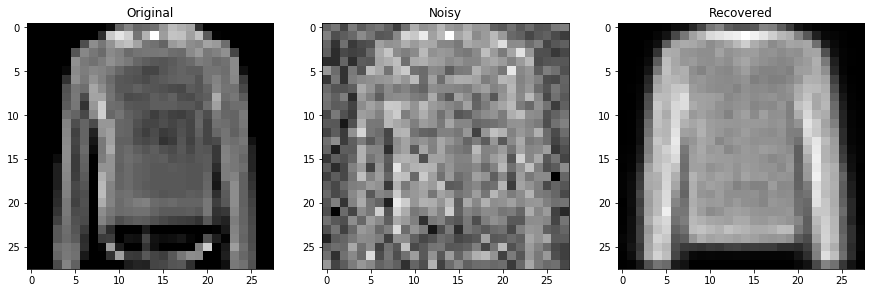

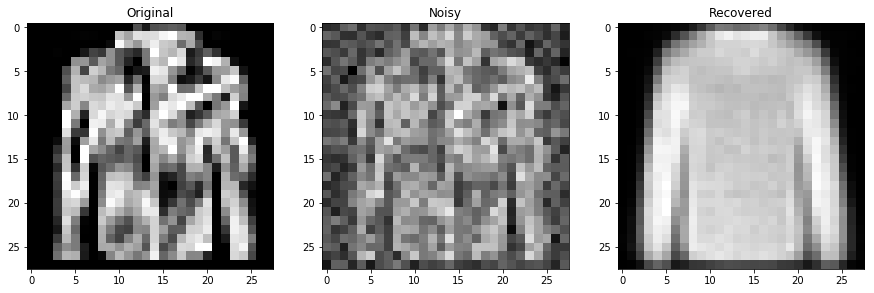

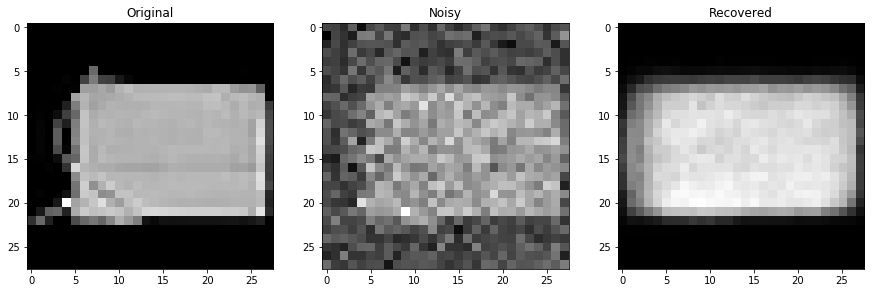

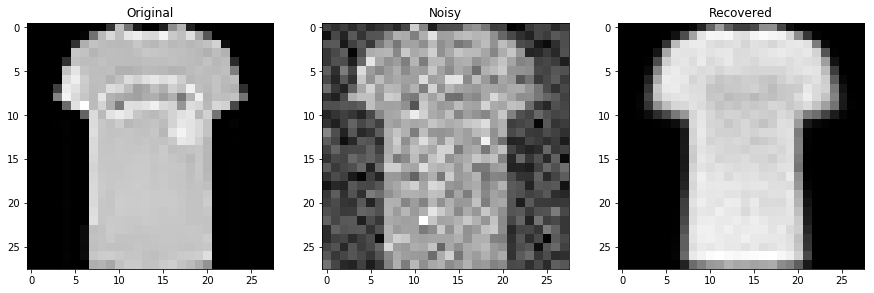

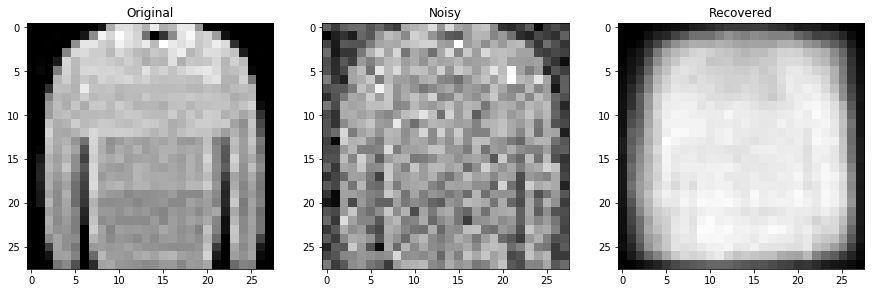

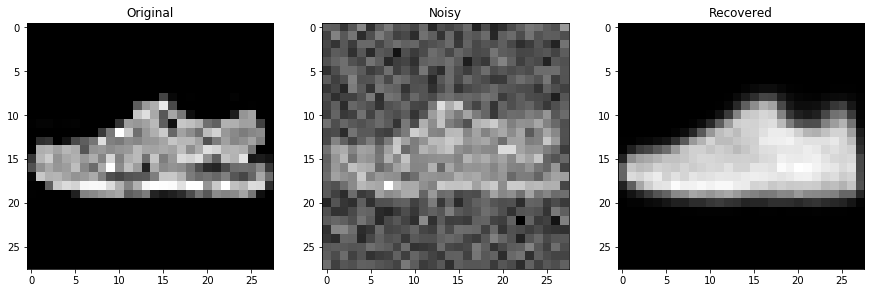

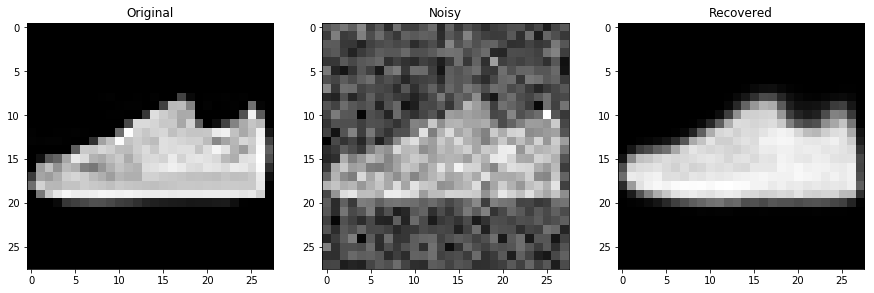

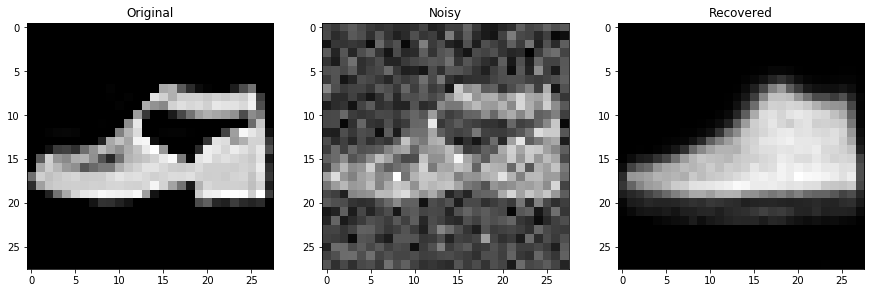

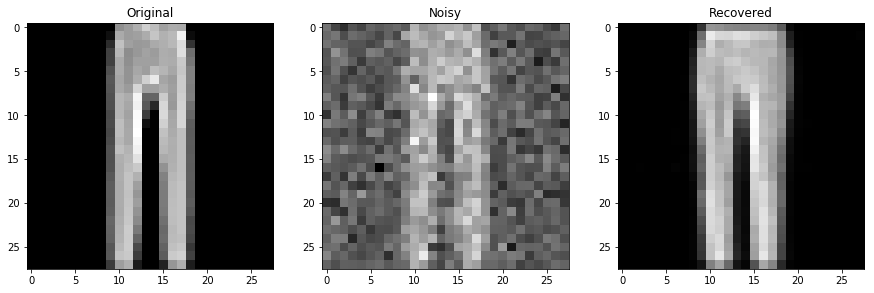

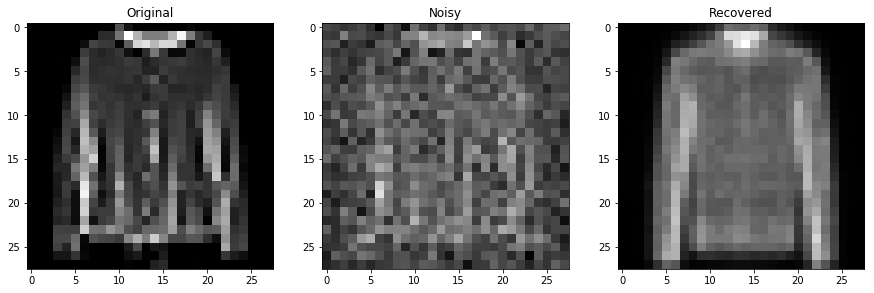

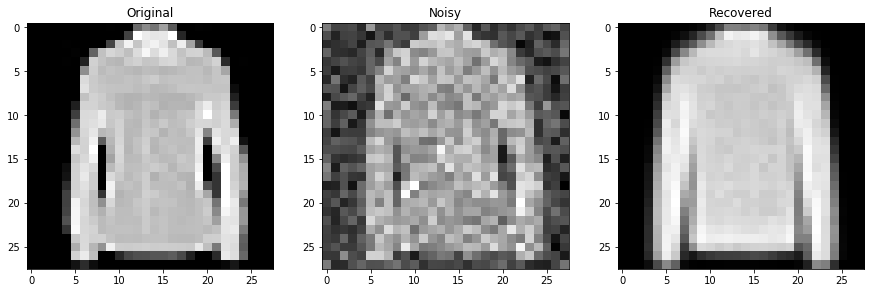

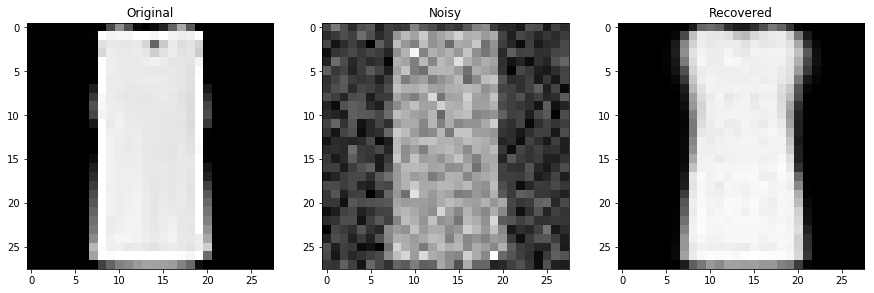

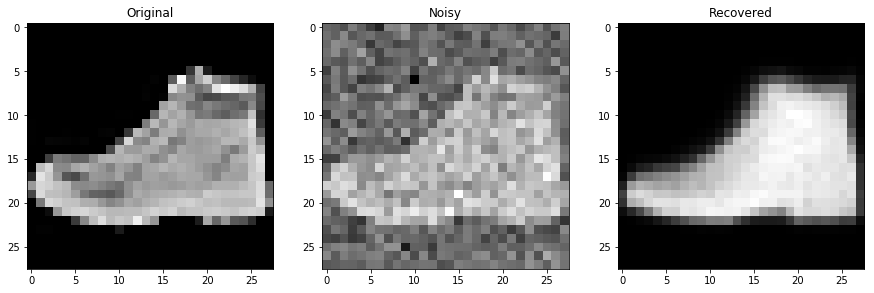

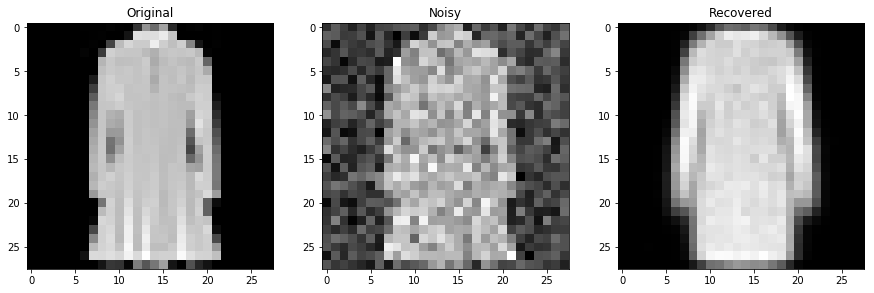

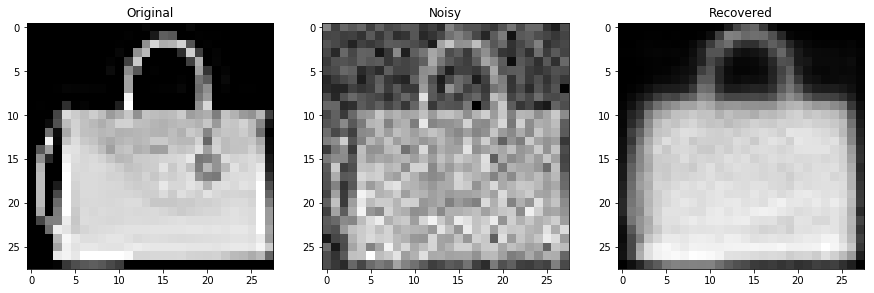

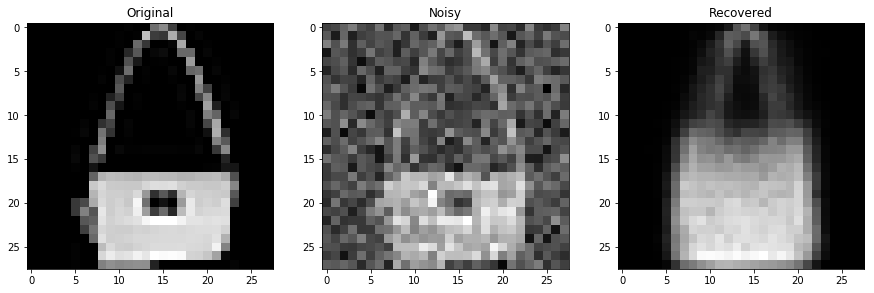

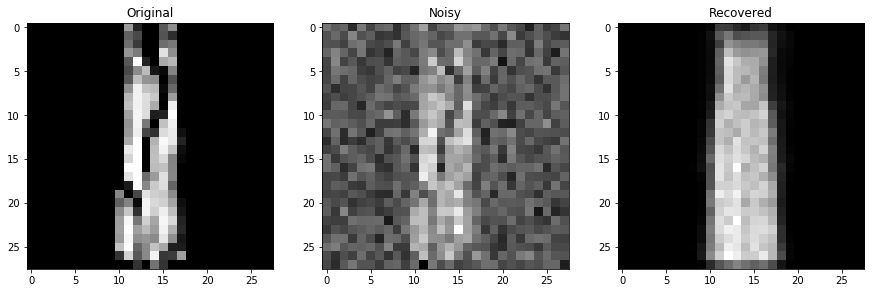

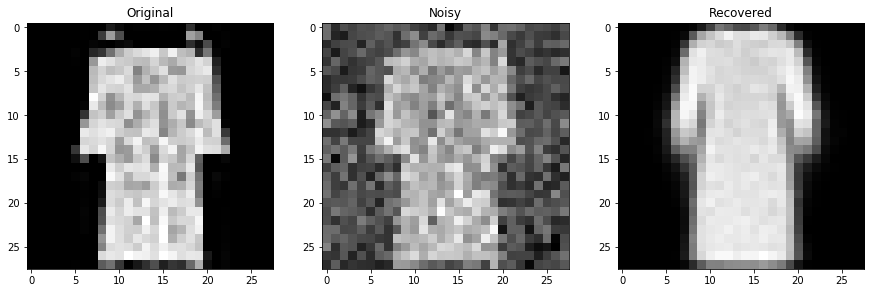

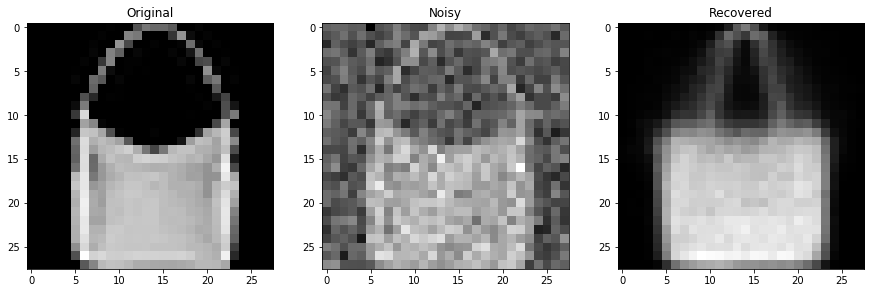

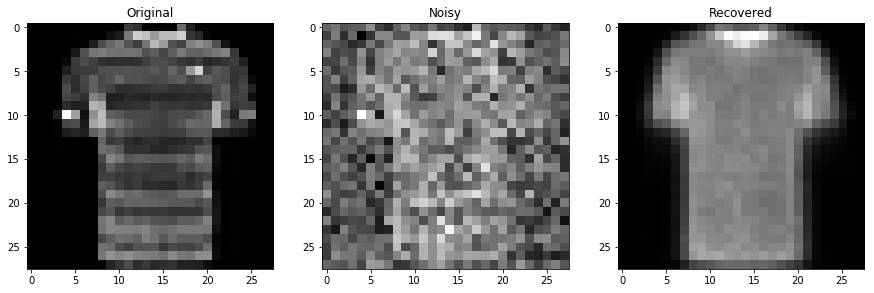

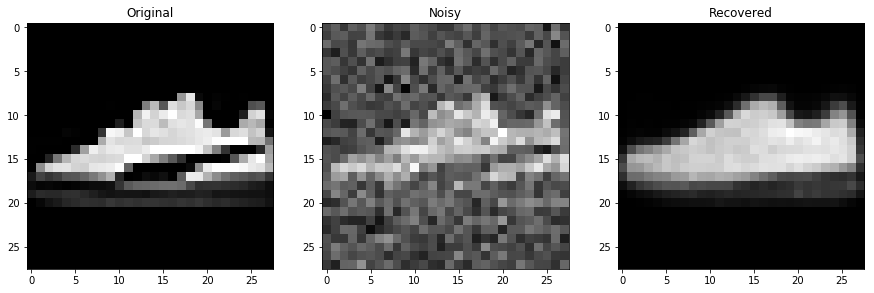

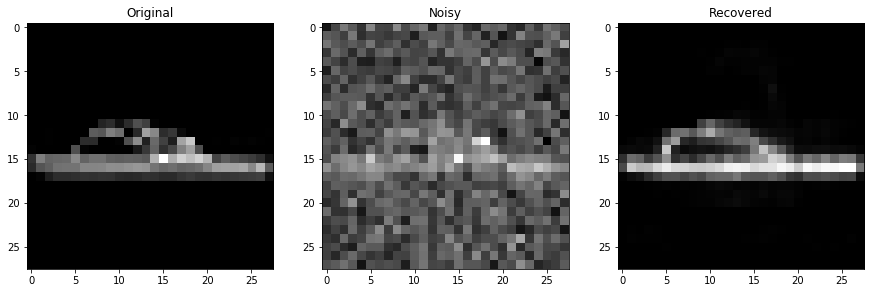

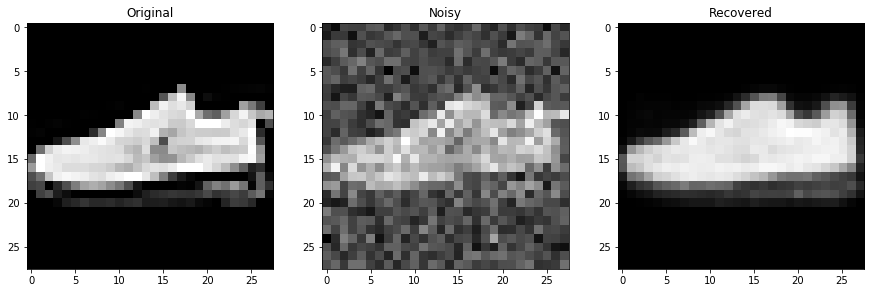

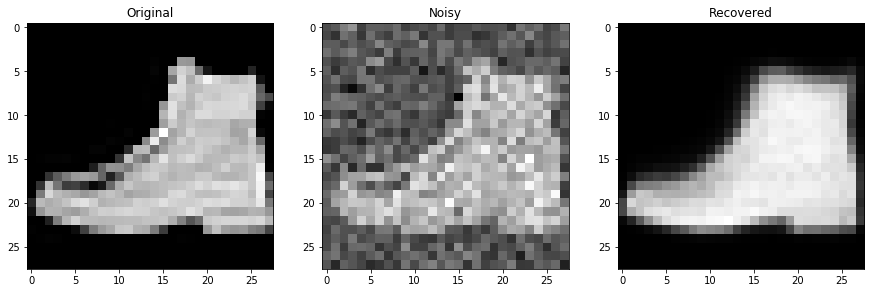

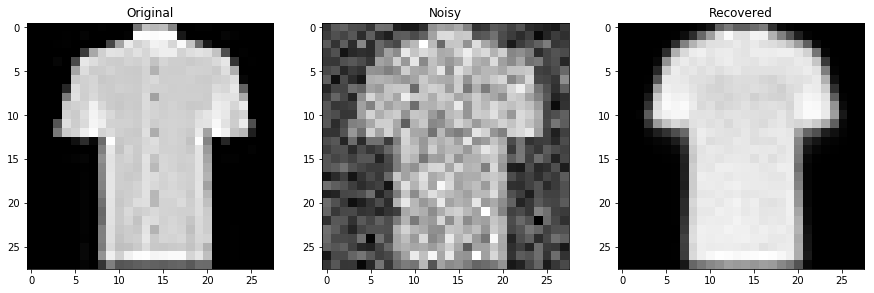

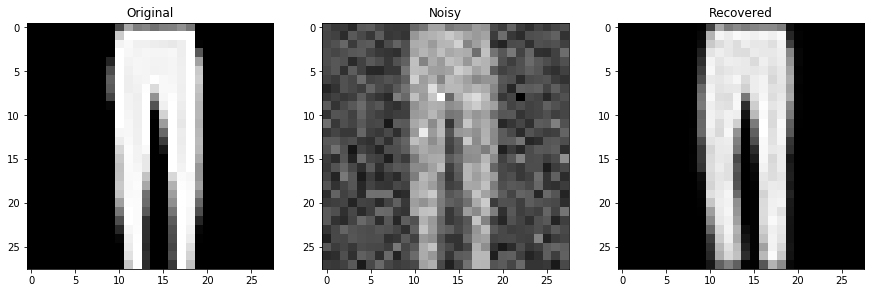

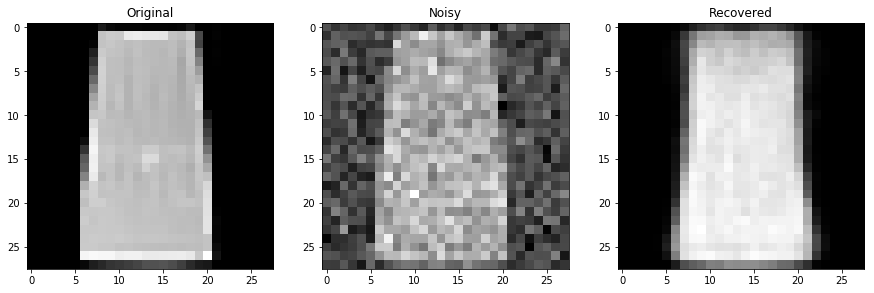

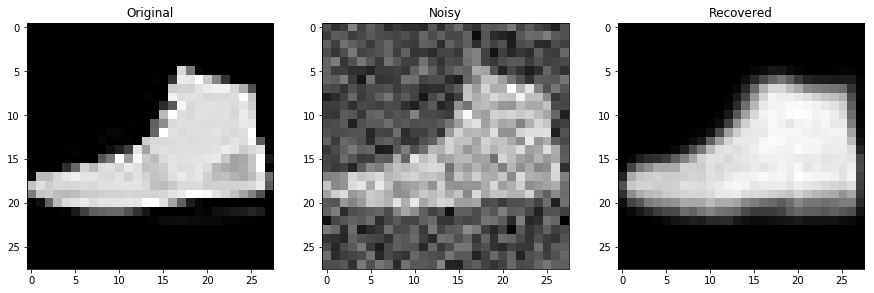

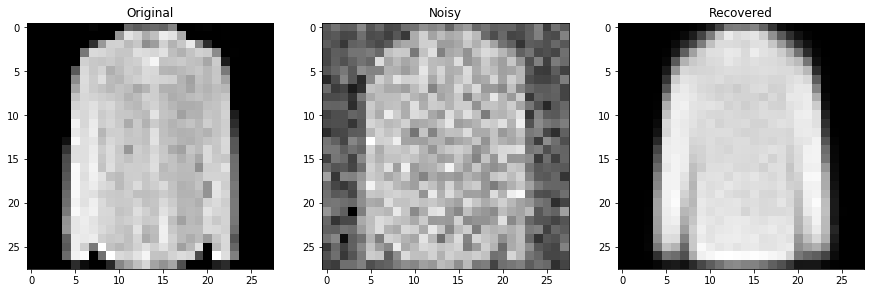

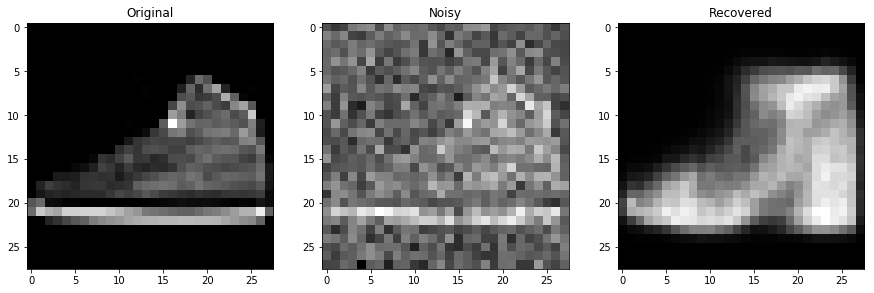

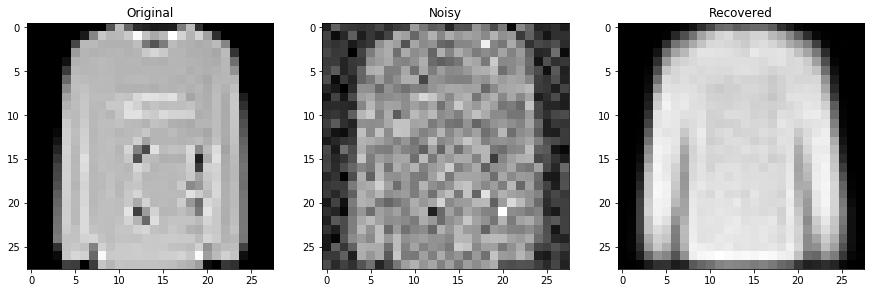

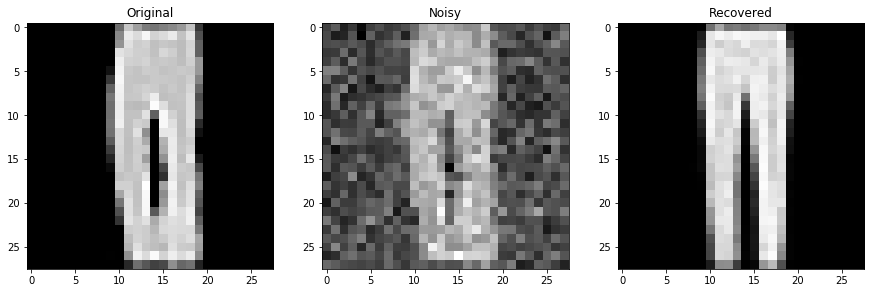

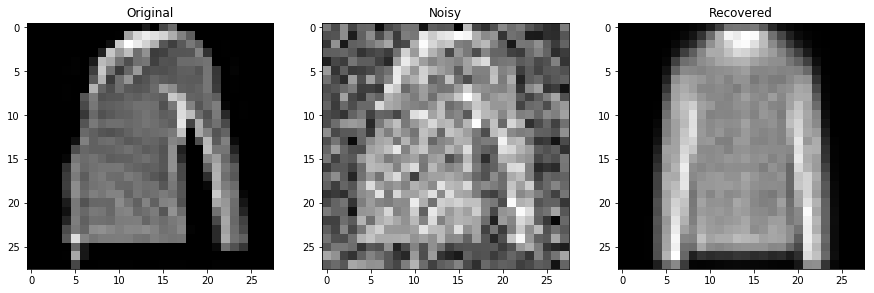

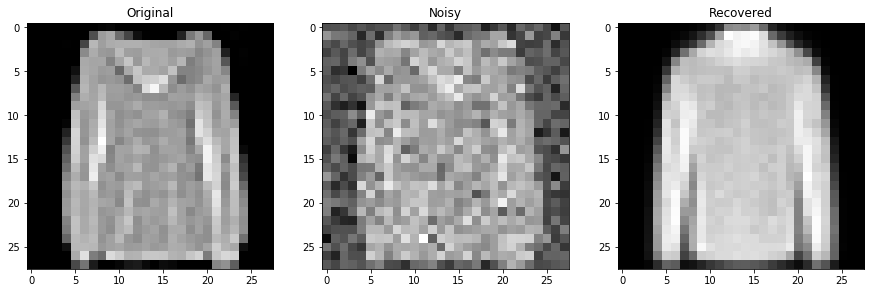

In [22]:
# 잡음 제거 시각화
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)


for i in range(50):
    # 다른 이미지 테스트 해보고 싶으면 testset.data[0] 의 인덱스변경
    sample_data = testset.data[i].view(-1, 28*28)
    sample_data = sample_data.type(torch.FloatTensor)/255.

    # add_noise() 함수로 잡음을 더해주고 모델에 통과
    original_x = sample_data[0]
    noisy_x = add_noise(original_x).to(DEVICE)
    _, recovered_x = autoencoder(noisy_x)

    # 시각화
    f, a = plt.subplots(1, 3, figsize=(15, 15))

    # 넘파이 행렬로 변환
    original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
    noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
    recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

    # 원본 사진
    a[0].set_title('Original')
    a[0].imshow(original_img, cmap='gray')

    # 오염된 원본 사진
    a[1].set_title('Noisy')
    a[1].imshow(noisy_img, cmap='gray')

    # 복원된 사진
    a[2].set_title('Recovered')
    a[2].imshow(recovered_img, cmap='gray')

    plt.show()